# Emotion Recognition & Detection

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# pip install wordcloud

In [3]:
# from mpl_toolkits.mplot3d import Axes3D
# from sklearn.preprocessing import StandardScaler
# from wordcloud import WordCloud, STOPWORDS
# from collections import defaultdict

In [4]:
df = pd.read_csv('tweet_emotions.csv')
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   content    40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


In [6]:
df.describe()

,tweet_id
count,4.000000e+04
mean,1.845184e+09
std,1.188579e+08
min,1.693956e+09
25%,1.751431e+09
50%,1.855443e+09
75%,1.962781e+09
max,1.966441e+09


In [7]:
df.isnull().sum()

tweet_id     0
sentiment    0
content      0
dtype: int64

In [8]:
df.nunique()

tweet_id     40000
sentiment       13
content      39827
dtype: int64

In [9]:
df.sentiment.unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [10]:
sentiment_to_label = {
    'empty': 0,
    'sadness': 1,
    'enthusiasm': 2,
    'neutral': 3,
    'worry': 4,
    'surprise': 5,
    'love': 6,
    'fun': 7,
    'hate': 8,
    'happiness': 9,
    'boredom': 10,
    'relief': 11,
    'anger': 12
}

df['sentiment_label'] = df['sentiment'].map(sentiment_to_label)

In [11]:
df.head()

,tweet_id,sentiment,content,sentiment_label
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...,0
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...,1
2,1956967696,sadness,Funeral ceremony...gloomy friday...,1
3,1956967789,enthusiasm,wants to hang out with friends SOON!,2
4,1956968416,neutral,@dannycastillo We want to trade with someone w...,3


In [12]:
# df['char_length'] = df['content'].apply(lambda x : len(x))
df['token_length'] = df['content'].apply(lambda x : len(x.split(" ")))

In [13]:
df.head()

,tweet_id,sentiment,content,sentiment_label,token_length
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...,0,19
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...,1,11
2,1956967696,sadness,Funeral ceremony...gloomy friday...,1,3
3,1956967789,enthusiasm,wants to hang out with friends SOON!,2,7
4,1956968416,neutral,@dannycastillo We want to trade with someone w...,3,15


## Data Visualization

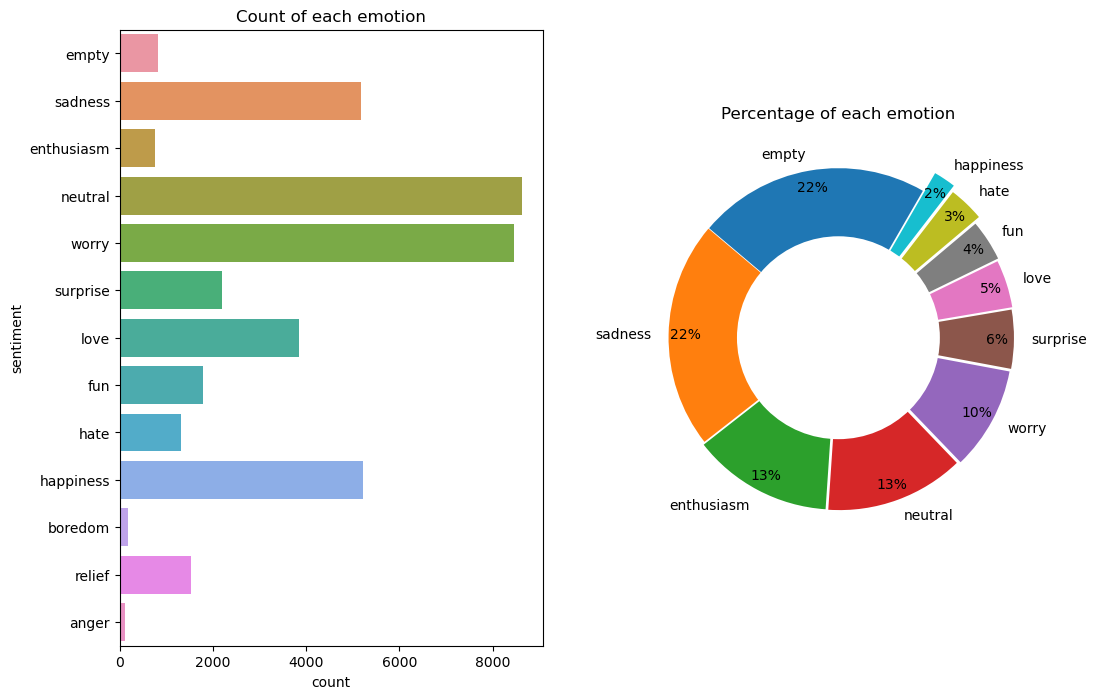

In [14]:
col = 'sentiment'
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
explode = list((np.array(list(df[col].dropna().value_counts()))/sum(list(df[col].dropna().value_counts())))[::-1])[:10]
labels = list(df[col].dropna().unique())[:10]
sizes = df[col].value_counts()[:10]
#ax.pie(sizes, explode=explode, colors=bo, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
sns.countplot(y =col, data = df, ax=ax1)
ax1.set_title("Count of each emotion")
ax2.set_title("Percentage of each emotion")
plt.show()

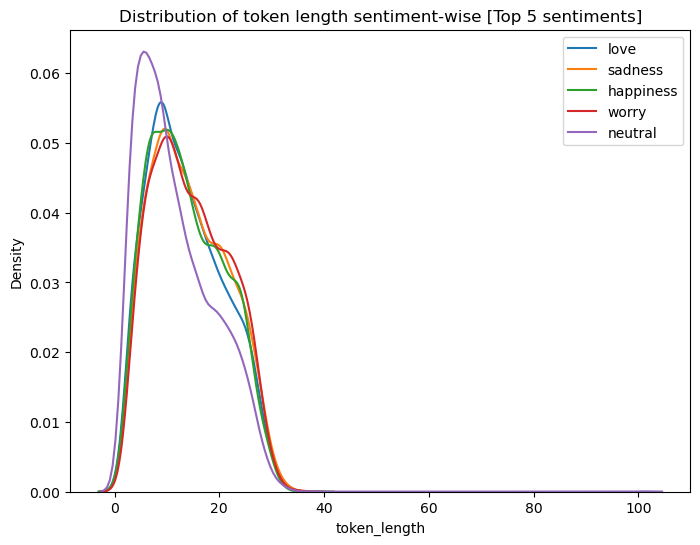

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
for sentiment in df['sentiment'].value_counts().sort_values()[-5:].index.tolist():
#     print(sentiment)
    sns.kdeplot(df[df['sentiment']==sentiment]['token_length'],ax=ax, label=sentiment)
ax.legend()
ax.set_title("Distribution of token length sentiment-wise [Top 5 sentiments]")
plt.show()

## Data Preprocessing

In [16]:
# !pip install inflect

In [17]:
# !pip install contractions

In [18]:
# !pip install bs4

In [19]:
from sklearn.preprocessing import LabelEncoder
import nltk
import inflect
import contractions

from bs4 import BeautifulSoup
import re, string, unicodedata

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

In [20]:
def text_preprocessing_platform(df, text_col, remove_stopwords=True):
    
    # Step 1: Denoise Text
    def denoise_text(text):
        # Strip HTML tags
        soup = BeautifulSoup(text, "html.parser")
        text = soup.get_text()
        # Replace contractions
        text = contractions.fix(text)
        return text
    
    # Step 2: Tokenization
    def tokenize(text):
        return nltk.word_tokenize(text)
    
    # Step 3: Text Normalization
    def remove_non_ascii(words):
        """Remove non-ASCII characters from list of tokenized words"""
        new_words = [unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
                     for word in words]
        return new_words
    
    def to_lowercase(words):
        """Convert all characters to lowercase from list of tokenized words"""
        return [word.lower() for word in words]
    
    def remove_punctuation(words):
        """Remove punctuation from list of tokenized words"""
        return [re.sub(r'[^\w\s]', '', word) for word in words if word.strip()]
    
    def replace_numbers(words):
        """Replace integer occurrences in list of tokenized words with textual representation"""
        p = inflect.engine()
        return [p.number_to_words(word) if word.isdigit() else word for word in words]
    
    def remove_stopwords(words):
        """Remove stop words from list of tokenized words"""
        stop_words = set(stopwords.words('english'))
        return [word for word in words if word not in stop_words]
    
    def stem_words(words):
        """Stem words in list of tokenized words"""
        stemmer = LancasterStemmer()
        return [stemmer.stem(word) for word in words]
    
    def lemmatize_verbs(words):
        """Lemmatize verbs in list of tokenized words"""
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(word, pos='v') for word in words]
    
    def normalize_text(words, remove_stopwords):
        words = remove_non_ascii(words)
        words = to_lowercase(words)
        words = remove_punctuation(words)
        words = replace_numbers(words)
        if remove_stopwords:
            words = remove_stopwords(words)
        # words = stem_words(words) # You can uncomment this line if you want stemming
        words = lemmatize_verbs(words)
        return words
    
    # Step 4: Text Preparation
    def text_prepare(text):
        text = denoise_text(text)
        words = normalize_text(tokenize(text), remove_stopwords)
        return ' '.join(words)
    
    # Apply text_prepare to the specified text column in the DataFrame
    df[text_col] = df[text_col].apply(text_prepare)
    
    return df

In [21]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\suman\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\suman\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [23]:
print("Before Text Preprocessing")
display(df.head()[['content']])
processed_df = text_preprocessing_platform(df, 'content', remove_stopwords=False)
print("After Text Preprocessing")
display(processed_df.head()[['content']])

Before Text Preprocessing


,content
0,@tiffanylue i know i was listenin to bad habi...
1,Layin n bed with a headache ughhhh...waitin o...
2,Funeral ceremony...gloomy friday...
3,wants to hang out with friends SOON!
4,@dannycastillo We want to trade with someone w...


After Text Preprocessing


,content
0,tiffanylue know listenin bad habit earlier st...
1,layin n bed headache ughhhh waitin call
2,funeral ceremony gloomy friday
3,want hang friends soon
4,dannycastillo want trade someone houston tick...


## Feature Extraction

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()

In [25]:
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_df['content'])
tfidf_matrix

<40000x45397 sparse matrix of type '<class 'numpy.float64'>'
	with 292883 stored elements in Compressed Sparse Row format>

In [26]:
# tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [27]:
# tfidf_df.head()

In [28]:
print("TF-IDF Matrix:")
print(tfidf_matrix.toarray())

TF-IDF Matrix:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [29]:
feature_names = tfidf_vectorizer.get_feature_names_out()

print("\nFeature Names:")
print(feature_names)


Feature Names:
['01theone' '079i12' '09casper' ... 'zzzzz' 'zzzzzzz' 'zzzzzzzzzzzzzzz']


## Model Training

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

In [31]:
x_train, x_test, y_train, y_test = train_test_split(tfidf_matrix, df.sentiment, test_size=0.2, random_state=42)

In [32]:
svm_classifier = SVC(kernel='linear')

In [33]:
svm_classifier.fit(x_train, y_train)

SVC(kernel='linear')

In [41]:
y_pred = svm_classifier.predict(x_test)

In [42]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.34525


In [43]:
print('Classification Report:\n')
print(classification_report(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        19
     boredom       0.00      0.00      0.00        31
       empty       0.00      0.00      0.00       162
  enthusiasm       0.00      0.00      0.00       163
         fun       0.14      0.01      0.03       338
   happiness       0.33      0.39      0.35      1028
        hate       0.42      0.18      0.25       268
        love       0.49      0.38      0.43       762
     neutral       0.33      0.57      0.42      1740
      relief       0.44      0.03      0.06       352
     sadness       0.37      0.23      0.28      1046
    surprise       0.38      0.04      0.06       425
       worry       0.33      0.46      0.38      1666

    accuracy                           0.35      8000
   macro avg       0.25      0.18      0.17      8000
weighted avg       0.34      0.35      0.31      8000



In [38]:
# Defining the classifiers and their respective hyperparameter grids for tuning
classifiers = {
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Multinomial Naive Bayes': MultinomialNB()
}

param_grids = {
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]},
    'Multinomial Naive Bayes': {'alpha': [0.1, 1, 10]}
}

In [ ]:
best_models = {}

for name, classifier in classifiers.items():
    param_grid = param_grids[name]
    
    grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')
    
    grid_search.fit(x_train, y_train)
    
    # Get the best model from GridSearchCV
    best_models[name] = grid_search.best_estimator_

In [ ]:
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} - Best Model Accuracy: {accuracy}")